In [44]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score

# Clustering Librairies import
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance

from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

from time import time

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

In [45]:
df = pd.read_csv("projet4_segmentation.csv", index_col=0)
df.head()

,payment_sequential,payment_type,payment_installments,payment_value,seller_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_purchase_month,order_purchase_dayofweek,...,sport,technology,toys_baby,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days,First_purchase_date,Last_Purchase_Date
0,1,credit_card,8,99.33,213b25e6f54661939f11710a6fddb871,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,2018-05-09 17:36:51,4,2,...,0.0,0.0,0.0,1.0,1,1.0,1,14.0,201804,201804
1,1,credit_card,4,93.72,213b25e6f54661939f11710a6fddb871,0e37385834260d6111727103a93e790a,2018-04-15 22:53:59,2018-04-20 00:07:39,4,6,...,0.0,0.0,0.0,1.0,1,4.0,1,4.0,201804,201804
2,1,credit_card,1,24.39,eaf6d55068dea77334e8477d3878d89e,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,2018-06-29 20:32:09,6,1,...,0.0,0.0,0.0,1.0,1,5.0,1,3.0,201806,201806
3,1,credit_card,1,65.71,cc419e0650a3c5ba77189a1882b7556a,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,2017-12-18 17:24:41,12,1,...,0.0,0.0,0.0,1.0,1,5.0,1,6.0,201712,201712
4,1,credit_card,2,65.71,cc419e0650a3c5ba77189a1882b7556a,49a332427c5be4c418541be8753c5238,2018-02-13 18:37:48,2018-02-16 17:48:45,2,1,...,0.0,0.0,0.0,1.0,1,4.0,1,3.0,201802,201802


In [46]:
df.shape

(154775, 33)

In [47]:
df.dtypes

payment_sequential                 int64
payment_type                      object
payment_installments               int64
payment_value                    float64
seller_id                         object
customer_id                       object
order_purchase_timestamp          object
order_delivered_customer_date     object
order_purchase_month               int64
order_purchase_dayofweek           int64
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
product_category_name             object
nb_products                        int64
books_cds_media                  float64
fashion_clothing_accessories     float64
flowers_gifts                    float64
groceries_food_drink             float64
health_beauty                    float64
home_furniture                   float64
other                            float64
sport                            float64
technology      

In [48]:
# K-Means Clustering (without PCA)

In [49]:
df.drop(["seller_id",
         "customer_id",
         "customer_unique_id",
         "customer_state",
           "customer_city",
        'order_purchase_month',
        'order_purchase_dayofweek',
         'Last_Purchase_Date',
         'First_purchase_date',
         'product_category_name',
        'order_purchase_timestamp',
        'order_delivered_customer_date',
        "payment_type"], 
        axis=1, inplace=True)

In [50]:
df.shape

(154775, 20)

In [51]:
cat_df = list(df.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns)
cat_df

[]

In [52]:
num_df = list(df.select_dtypes(include=['int64','float64', 'uint8']).columns)
num_df

['payment_sequential',
 'payment_installments',
 'payment_value',
 'customer_zip_code_prefix',
 'nb_products',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'groceries_food_drink',
 'health_beauty',
 'home_furniture',
 'other',
 'sport',
 'technology',
 'toys_baby',
 'nb_items',
 'nb_review',
 'review_score_mean',
 'nb_orders',
 'delivery_delta_days']

In [53]:
# On prepare le preprocessor 
scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, num_df)])

In [54]:
# Elbow method: determination of the best K

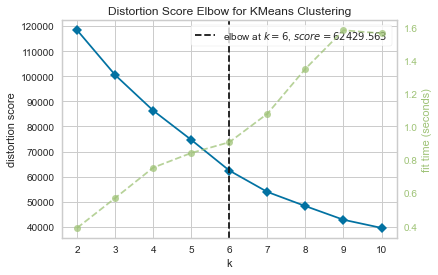

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [55]:
X = df.copy()

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

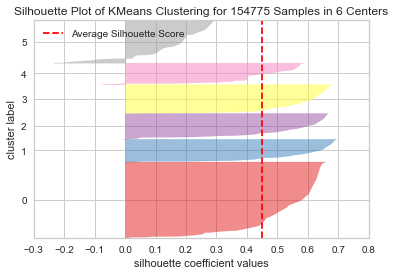

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 154775 Samples in 6 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [56]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

# Silhouette Visualizer
silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

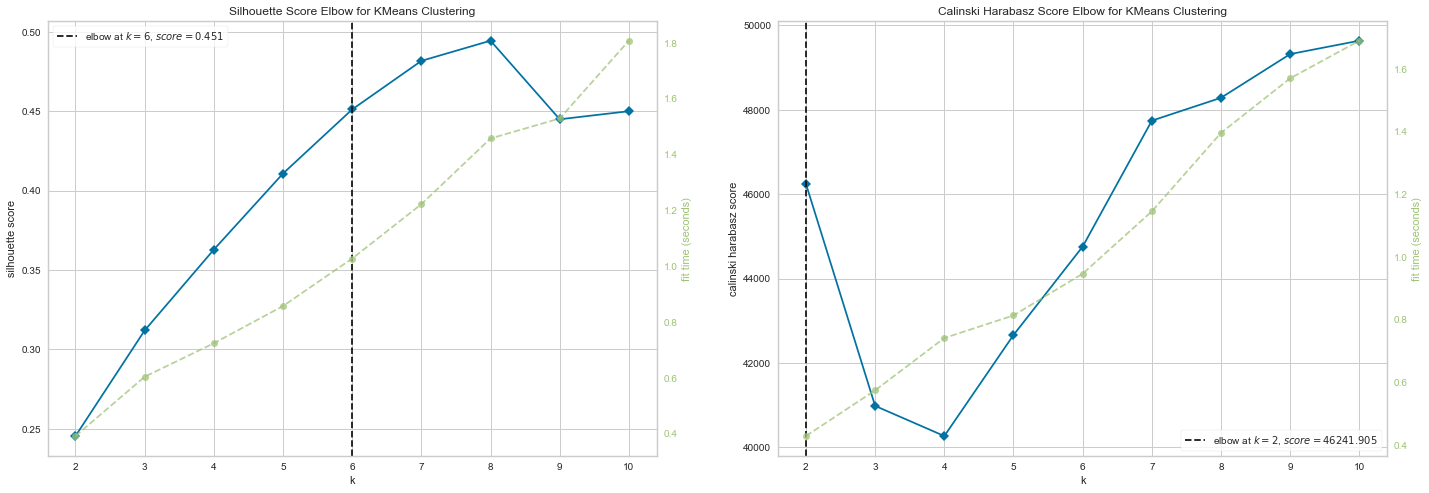

In [57]:
# Elbow method with differents metrics
metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(2,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()



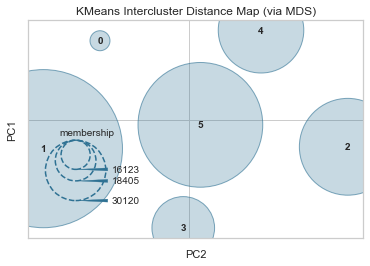

<AxesSubplot:title={'center':'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [58]:
# Intercluster distance Map with best k
distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

In [24]:
# Analysis of clusters

In [60]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
df["kmeans_label"] = kmeans_labels

In [61]:
kmeans_clusters_means = df.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

,kmeans_label,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,nb_products,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,...,home_furniture,other,sport,technology,toys_baby,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days
0,0,1.067506,3.255313,168.003512,35945.291805,1.396135,0.034533,0.171470,0.404469,0.046686,...,0.017698,0.013050,0.008666,0.008965,0.284932,2.243857,1.396135,4.161426,1.549143,12.053327
1,1,1.075330,2.917441,178.062398,35033.382956,1.521441,0.000217,0.007066,0.001848,0.003207,...,0.031360,0.922441,0.004783,0.012066,0.006196,1.939181,1.521441,4.169792,1.302734,11.855644
2,2,1.165503,3.379998,170.890553,32833.286859,2.145336,0.000681,0.005636,0.006317,0.000700,...,0.947914,0.014642,0.002118,0.008435,0.007128,3.755097,2.145336,3.989005,1.805120,12.697118
3,3,1.065532,2.401580,198.218231,39100.461261,1.711785,0.000049,0.003852,0.000536,0.001707,...,0.008972,0.003803,0.001219,0.973183,0.002731,2.597055,1.711785,3.992759,1.314691,13.101565
4,4,1.053298,2.372431,131.397813,27994.136473,1.365451,0.000000,0.051928,0.002348,0.003001,...,0.016178,0.036858,0.866919,0.008676,0.002936,4.977298,1.365451,4.429121,4.425664,10.092309
5,5,1.061574,3.061760,155.135883,34140.911577,1.445836,0.000806,0.004341,0.000558,0.005953,...,0.014696,0.003844,0.004341,0.006449,0.003224,1.896881,1.445836,4.219632,1.302102,11.746822


In [62]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,nb_products,books_cds_media,fashion_clothing_accessories,flowers_gifts,groceries_food_drink,health_beauty,home_furniture,other,sport,technology,toys_baby,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days
kmeans_label,,,,,,,,,,,,,,,,,,,,
0,0.002700,0.135638,0.012295,0.353034,0.006389,0.034533,0.171470,0.404469,0.046686,0.009530,0.017698,0.013050,0.008666,0.008965,0.284932,0.016809,0.006389,0.790356,0.039225,0.052887
1,0.003013,0.121560,0.013031,0.343821,0.008410,0.000217,0.007066,0.001848,0.003207,0.010816,0.031360,0.922441,0.004783,0.012066,0.006196,0.012692,0.008410,0.792448,0.021624,0.051941
2,0.006620,0.140833,0.012507,0.321593,0.018473,0.000681,0.005636,0.006317,0.000700,0.006428,0.947914,0.014642,0.002118,0.008435,0.007128,0.037231,0.018473,0.747251,0.057509,0.055967
3,0.002621,0.100066,0.014507,0.384912,0.011480,0.000049,0.003852,0.000536,0.001707,0.003949,0.008972,0.003803,0.001219,0.973183,0.002731,0.021582,0.011480,0.748190,0.022478,0.057902
4,0.002132,0.098851,0.009616,0.272701,0.005894,0.000000,0.051928,0.002348,0.003001,0.011155,0.016178,0.036858,0.866919,0.008676,0.002936,0.053747,0.005894,0.857280,0.244690,0.043504
5,0.002463,0.127573,0.011354,0.334804,0.007191,0.000806,0.004341,0.000558,0.005953,0.955788,0.014696,0.003844,0.004341,0.006449,0.003224,0.012120,0.007191,0.804908,0.021579,0.051420


In [65]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()
    
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)
        ))

    fig.update_layout(
        polar=dict(
        radialaxis=dict(
          visible=True,
          range=[0, 1]
        )),
        showlegend=True,
        title={
            'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="blue",
        title_font_size=18)

    fig.show()

In [66]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

In [67]:
# Clustering without product categories

In [69]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X_new = X.drop(categories_col, axis=1)
X_new.head()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,nb_products,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days
0,1,8,99.33,39801,1,1.0,1,1.0,1,14.0
1,1,4,93.72,14781,1,1.0,1,4.0,1,4.0
2,1,1,24.39,2422,1,1.0,1,5.0,1,3.0
3,1,1,65.71,2652,1,1.0,1,5.0,1,6.0
4,1,2,65.71,13308,1,1.0,1,4.0,1,3.0


In [70]:
def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Elbow visualizer
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Set best K
    K = KBest
    model.set_params(n_clusters=K)

    # Silhouette Visualizer
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # Intercluster distance Map with best k
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

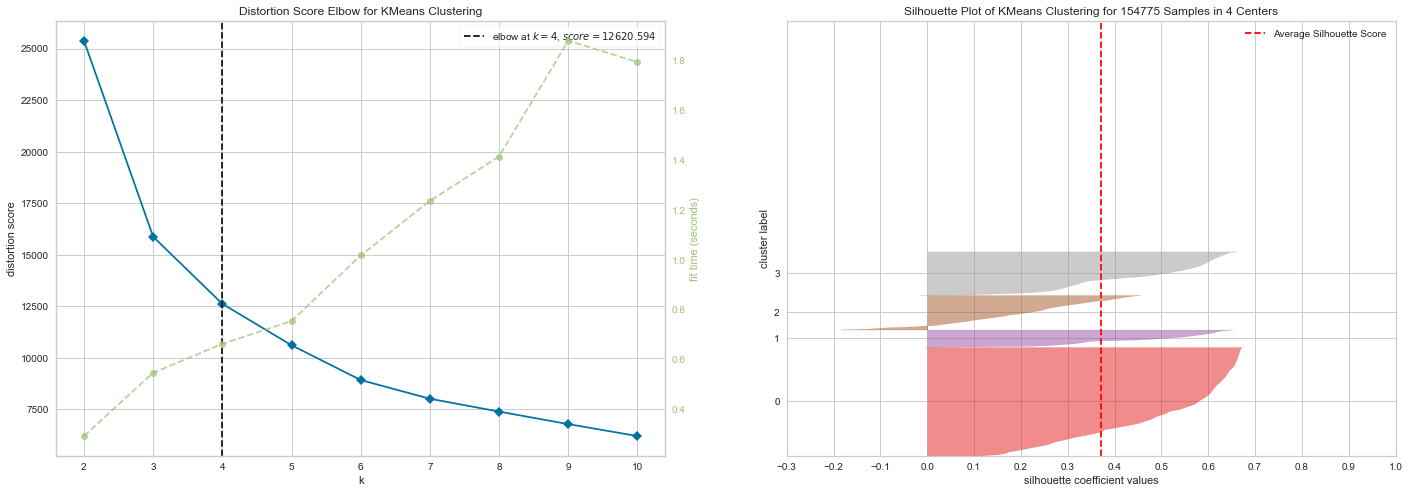

In [71]:
K = clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_new, 
                metric="distortion",
                elbow=True,
                mds=False,
                KBest=None)

In [72]:
# KMeans Pipeline with best K
kmeans_model_new = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_new.fit(X_new)

# Kmeans labels
kmeans_labels_new = kmeans_model_new.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_new = scaler.fit_transform(X_new)
X_scaled_new = pd.DataFrame(X_scaled_new, index=X_new.index, columns=X_new.columns)
X_scaled_new["kmeans_label"] = kmeans_labels_new

# Group by cluster
X_scaled_clusters_new = X_scaled_new.groupby("kmeans_label").mean()

# Plot Radar chart
plot_radars(data=X_scaled_clusters_new,
            group="kmeans_label")

In [37]:
## Dimensional reduction - PCA

In [73]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_new)
X_projected = pca.transform(X_new)

In [43]:
## Eboulis des valeurs propres

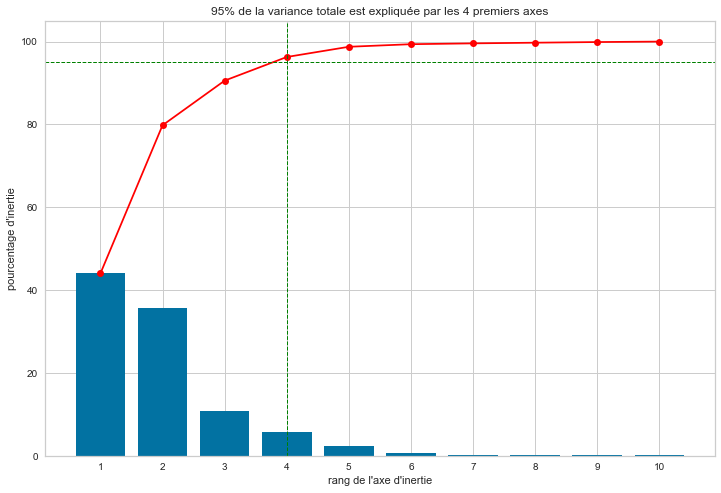

In [74]:
# Explained variance
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Plot of cumulated variance
plt.figure(figsize=(12,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=95, linestyle="--", 
            color="green",
            linewidth=1)

limit = 95
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)


In [77]:
def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            #détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            #affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="grey", alpha=0.5)
            # et noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            #ajouter les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            #ajouter un cercle 
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # nom des axes, avec le pourcentage d'inertie expliqué
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="blue", fontsize=18)        
    plt.show(block=False)

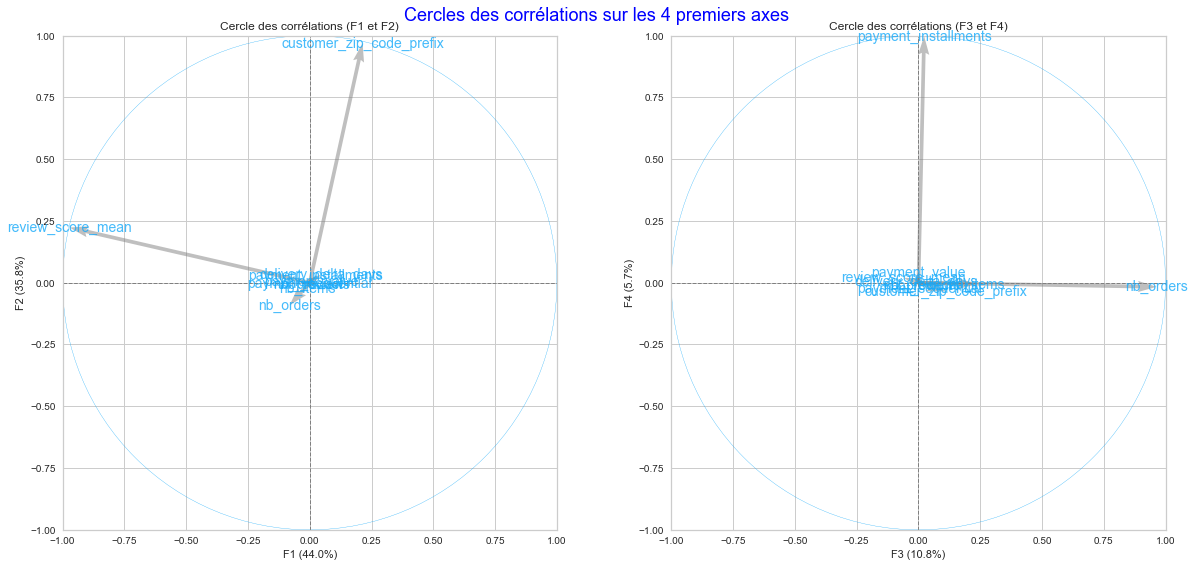

In [78]:
# Principal component space
pcs = pca.named_steps['pca'].components_

# Plot correlation circle
cerle_corr(pcs,
           4,
           pca.named_steps['pca'],
           [(0,1),(2,3)],
           labels = np.array(X_new.columns))

In [79]:
pcs= pd.DataFrame(X_projected, index=X_new.index, columns=["F"+str(i+1) for i in range(10)])
pcs

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
0,0.778876,-0.106586,-0.007931,0.190158,-0.028878,-0.023892,0.015581,-0.000246,-0.001013,-0.011796
1,-0.010515,-0.190190,-0.083025,0.047464,-0.019695,-0.033716,0.005367,-0.000043,0.000938,-0.004642
2,-0.283607,-0.258970,-0.114213,-0.068140,-0.018328,-0.024001,0.000837,0.000037,0.002342,-0.004839
3,-0.282443,-0.256243,-0.114098,-0.068058,-0.018470,-0.009744,-0.000500,0.000052,0.002475,-0.002256
4,-0.016028,-0.207054,-0.086525,-0.035259,-0.021229,-0.037576,0.003455,-0.000044,0.002015,-0.003778
...,...,...,...,...,...,...,...,...,...,...
154770,-0.117825,0.474126,-0.030142,-0.010890,-0.015062,0.007902,0.003332,0.000061,-0.000818,-0.005127
154771,-0.210897,0.066769,-0.076410,-0.038095,-0.016306,-0.037431,0.002230,0.000023,0.001059,-0.002662
154772,-0.281659,-0.250972,-0.113368,-0.068403,-0.018372,-0.019548,0.000693,0.000041,0.002315,-0.004807
154773,-0.197414,0.121622,-0.071752,-0.081527,-0.017807,0.017791,0.000067,0.000075,0.001232,-0.004064


In [56]:
# KMeans after size reduction

In [82]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:3])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_new["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_new.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,nb_products,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days
kmeans_label_pca,,,,,,,,,,
0,0.003506,0.135359,0.014944,0.304594,0.016764,0.025245,0.016965,0.193525,0.029314,0.074112
1,0.002357,0.136384,0.014038,0.786065,0.009361,0.023083,0.009290,0.892473,0.041147,0.065526
2,0.005125,0.119918,0.011079,0.169831,0.011080,0.021743,0.011081,0.941022,0.035874,0.042171
3,0.000000,0.111610,0.005528,0.046761,0.001857,0.186389,0.000955,0.903805,0.911205,0.022335


In [83]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

4

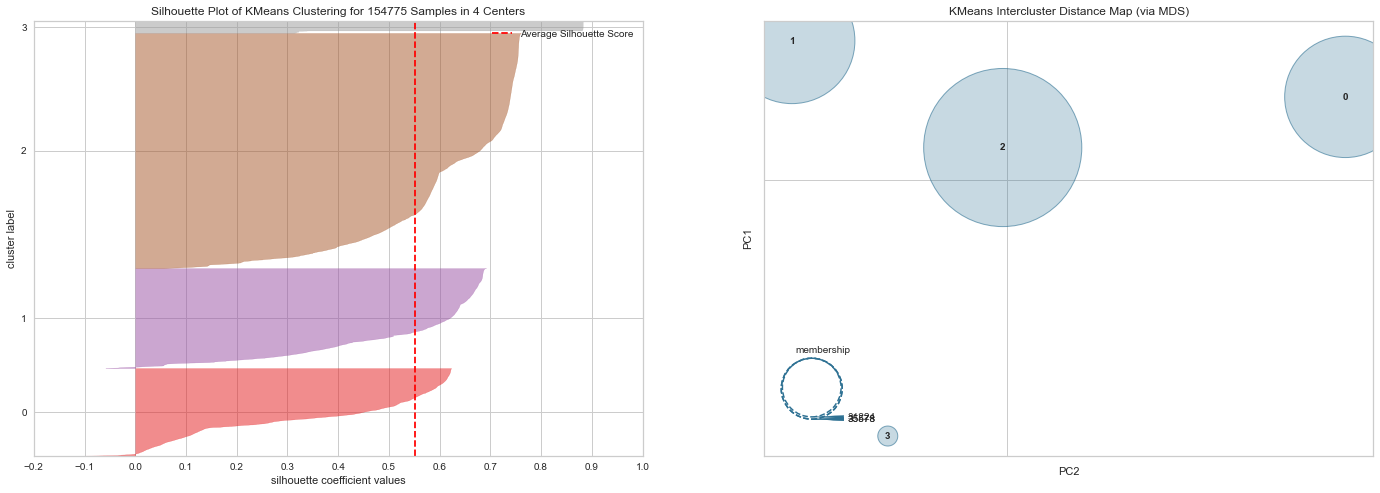

In [84]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:3], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

In [85]:
# stability at K-Means initialization

In [86]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:3]

In [88]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Test differents metrics on pred labels
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Show the results
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [89]:
print("Scores de stabilité à l'initialisation")
print(53 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(53 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name=str(i), 
                  data=pca_data, labels=labels)

print(53 * '_')

Scores de stabilité à l'initialisation
_____________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_____________________________________________________
0        	0.100s	6074	1.000	-3.117	1.000
1        	0.078s	6074	1.000	-3.125	1.000
2        	0.107s	6074	1.000	-3.121	1.000
3        	0.079s	7868	0.743	5.782	0.681
4        	0.075s	6074	0.999	-3.113	0.999
5        	0.075s	7828	0.844	4.112	0.831
6        	0.076s	6074	1.000	-3.125	1.000
7        	0.116s	6128	0.966	-1.329	0.955
8        	0.081s	6074	1.000	-3.125	1.000
9        	0.106s	6074	1.000	-3.117	1.000
_____________________________________________________


In [90]:
# Temporal stability of the segmentation

In [91]:
df = pd.read_csv("projet4_segmentation.csv", index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154775 entries, 0 to 154774
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   payment_sequential             154775 non-null  int64  
 1   payment_type                   154775 non-null  object 
 2   payment_installments           154775 non-null  int64  
 3   payment_value                  154775 non-null  float64
 4   seller_id                      154775 non-null  object 
 5   customer_id                    154775 non-null  object 
 6   order_purchase_timestamp       154775 non-null  object 
 7   order_delivered_customer_date  154775 non-null  object 
 8   order_purchase_month           154775 non-null  int64  
 9   order_purchase_dayofweek       154775 non-null  int64  
 10  customer_unique_id             154775 non-null  object 
 11  customer_zip_code_prefix       154775 non-null  int64  
 12  customer_city                 

In [92]:
datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
for col in datetime_cols:
        df[col] = df[col].astype('datetime64[ns]')

In [93]:
print(df["order_purchase_timestamp"].min())
print(df["order_purchase_timestamp"].max())

2016-10-03 09:44:50
2018-08-29 15:00:37


In [94]:
def make_dataset(data, initial=False, period=1):
   
    # Select orders on period
    start=data["order_purchase_timestamp"].min()
    if(initial == True):
        period = 12
    else:
        period = 12+period
    stop=start + pd.DateOffset(months=period)
        
    data = data[(data["order_purchase_timestamp"]>=start)
                              & (data["order_purchase_timestamp"]<stop)]
    
    return data


In [95]:
# the first year
data_init = make_dataset(df, initial=True, period=1)

In [96]:
data_init

,payment_sequential,payment_type,payment_installments,payment_value,seller_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_purchase_month,order_purchase_dayofweek,...,sport,technology,toys_baby,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days,First_purchase_date,Last_Purchase_Date
8,2,voucher,1,50.00,cc419e0650a3c5ba77189a1882b7556a,a692cee8697769980ec9fa9f5170fc11,2017-09-13 11:34:35,2017-09-26 16:11:37,9,2,...,0.0,0.0,0.0,2.0,2,1.0,1,13.0,201709,201709
9,1,credit_card,1,21.14,cc419e0650a3c5ba77189a1882b7556a,a692cee8697769980ec9fa9f5170fc11,2017-09-13 11:34:35,2017-09-26 16:11:37,9,2,...,0.0,0.0,0.0,2.0,2,1.0,1,13.0,201709,201709
11,1,boleto,1,72.14,cc419e0650a3c5ba77189a1882b7556a,a3e48975d6250420ce214a7f3c7ebefc,2017-08-28 22:07:36,2017-09-08 17:57:59,8,0,...,0.0,0.0,0.0,1.0,1,5.0,1,11.0,201708,201708
12,1,credit_card,1,64.77,cc419e0650a3c5ba77189a1882b7556a,11f80f375a9a1438afcdba2e501750f1,2017-07-17 20:30:21,2017-07-21 19:39:46,7,0,...,0.0,0.0,0.0,1.0,1,5.0,1,4.0,201707,201707
20,1,boleto,1,65.71,cc419e0650a3c5ba77189a1882b7556a,ba9205e1ca24a9ad48a44f552bbb497f,2017-09-18 06:21:28,2017-09-27 19:38:00,9,0,...,0.0,0.0,0.0,1.0,1,5.0,1,10.0,201709,201709
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154758,1,credit_card,1,108.89,cb9fb4ca75d7ba8437480e8dde64fe98,f6d20984abb578ea47f9f68ddb947966,2017-08-06 21:38:03,2017-08-16 19:41:49,8,6,...,0.0,0.0,0.0,1.0,1,5.0,1,10.0,201708,201708
154759,1,boleto,1,147.67,2be17df1c49978426251562096c3cc09,9a9a85e7b6a53d3b2fe85bfa4b6f20f0,2017-07-07 13:18:22,2017-07-17 23:47:32,7,4,...,0.0,0.0,0.0,1.0,1,4.0,1,10.0,201707,201707
154761,1,credit_card,1,71.15,4830e40640734fc1c52cd21127c341d4,c30a6a79a913a05c611e56edc0b4fd37,2017-09-13 13:13:15,2017-10-02 14:48:02,9,2,...,0.0,0.0,0.0,1.0,1,5.0,1,19.0,201709,201709
154768,1,credit_card,4,83.23,aba1721a889e04decc910aa13b768ef4,0c320426834dddd6c276e7b22b715831,2017-05-08 16:43:57,2017-05-16 14:37:55,5,0,...,0.0,0.0,0.0,1.0,1,5.0,1,8.0,201705,201705


In [97]:
data_init.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45815 entries, 8 to 154770
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   payment_sequential             45815 non-null  int64         
 1   payment_type                   45815 non-null  object        
 2   payment_installments           45815 non-null  int64         
 3   payment_value                  45815 non-null  float64       
 4   seller_id                      45815 non-null  object        
 5   customer_id                    45815 non-null  object        
 6   order_purchase_timestamp       45815 non-null  datetime64[ns]
 7   order_delivered_customer_date  45815 non-null  datetime64[ns]
 8   order_purchase_month           45815 non-null  int64         
 9   order_purchase_dayofweek       45815 non-null  int64         
 10  customer_unique_id             45815 non-null  object        
 11  customer_zip_c

In [98]:
print(data_init["order_purchase_timestamp"].min())
print(data_init["order_purchase_timestamp"].max())

2016-10-03 09:44:50
2017-10-03 09:29:51


In [99]:
unitil_col=["seller_id",
         "customer_id",
         "customer_unique_id",
         "customer_state",
           "customer_city",
        'order_purchase_month',
        'order_purchase_dayofweek',
         'Last_Purchase_Date',
         'First_purchase_date',
         'product_category_name',
        'order_purchase_timestamp',
        'order_delivered_customer_date',
        "payment_type"]

In [100]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']

In [101]:
# Remove categories and unitules variables
data_init.drop(categories_col, axis=1, inplace=True)
data_init.drop(unitil_col, axis=1, inplace=True)
data_init.head()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,nb_products,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days
8,2,1,50.00,22723,2,2.0,2,1.0,1,13.0
9,1,1,21.14,22723,2,2.0,2,1.0,1,13.0
11,1,1,72.14,35498,1,1.0,1,5.0,1,11.0
12,1,1,64.77,8020,1,1.0,1,5.0,1,4.0
20,1,1,65.71,13142,1,1.0,1,5.0,1,10.0


In [102]:
# the total period of the orders to be covered
orders = df["order_purchase_timestamp"]
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 22 mois.


In [103]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [104]:
# 18 month: period=6
df = pd.read_csv("projet4_segmentation.csv", index_col=0)

datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
for col in datetime_cols:
        df[col] = df[col].astype('datetime64[ns]')
        
data_six = make_dataset(df, initial=True, period=6)
# Remove categories and unitules variables
data_six.drop(categories_col, axis=1, inplace=True)
data_six.drop(unitil_col, axis=1, inplace=True)
#Filter on initial customer client
data_six = data_six[data_six.index.isin(data_init.index)]
kmeans_six = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_six.fit(data_six)
six_labels = kmeans_six.named_steps['kmeans'].labels_
ARI_six = adjusted_rand_score(init_labels, kmeans_six[1].labels_)

In [105]:
ARI_six

1.0

In [106]:
ARI_score = []
for p in np.arange(1,(time_delta-12+1),1):
    # Create dataset for period
    data_period = make_dataset(df, 
                                   initial=False, 
                                   period=p)
    
    data_period.drop(categories_col, axis=1, inplace=True)
    data_period.drop(unitil_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ARI_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ARI_score.append([p,ARI_p])

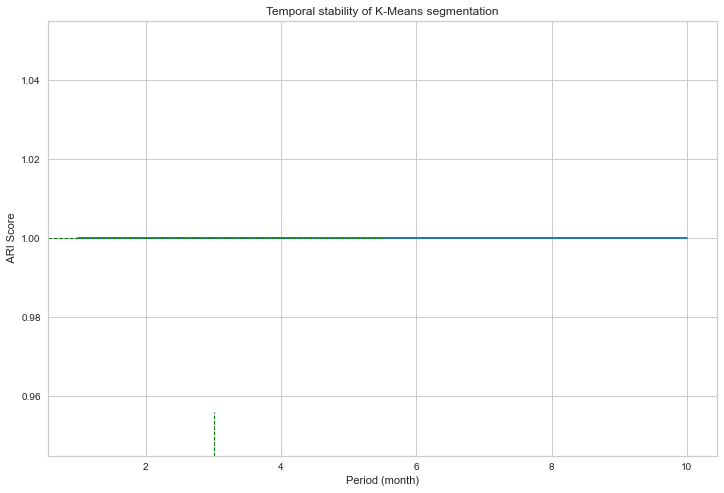

In [107]:
ARI_score = pd.DataFrame(ARI_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ARI_score, x="periode", y="ARI")
plt.axhline(y=ARI_score.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)
plt.axvline(x=ARI_score.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ARI_score.iloc[2][1]),
            linewidth=1)
plt.xlabel("Period (month)")
plt.ylabel(" ARI Score")
plt.title("Temporal stability of K-Means segmentation")
plt.show()


In [145]:
## DBSCAN

In [85]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X_new)
X = pd.DataFrame(X, index=X_new.index, columns=X_new.columns)

In [86]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(X)

In [87]:
principalComponents

array([[-0.62121065,  1.60473204,  0.60809363],
       [-0.5347239 , -0.59620686, -0.01587634],
       [-0.5056915 , -1.48098958, -0.74080555],
       ...,
       [-0.51137238, -1.41007367, -0.74976337],
       [-0.62610554, -0.20043494, -0.871964  ],
       [-0.65504619,  0.18658148, -0.33506286]])

In [88]:
PCA_dataset = pd.DataFrame(data = principalComponents, columns = ['Component 1', 'Component 2', 'Component 3'] )
PCA_dataset.head()

,Component 1,Component 2,Component 3
0,-0.621211,1.604732,0.608094
1,-0.534724,-0.596207,-0.015876
2,-0.505691,-1.480990,-0.740806
3,-0.512869,-1.253211,-0.687641
4,-0.514915,-0.877647,-0.483003


In [89]:
component1 = PCA_dataset['Component 1']
component2 = PCA_dataset['Component 2']
component3 = PCA_dataset['Component 3']

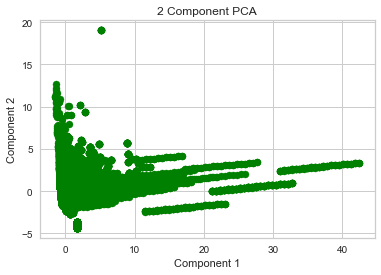

In [90]:
plt.figure()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('2 Component PCA')
plt.scatter(PCA_dataset['Component 1'], PCA_dataset['Component 2'], c = 'green', s=50)

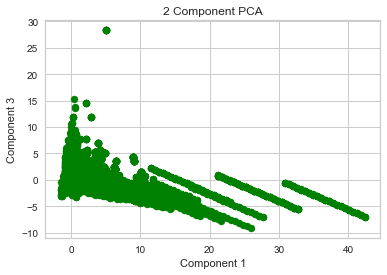

In [91]:
plt.figure()
plt.xlabel('Component 1')
plt.ylabel('Component 3')
plt.title('2 Component PCA')
plt.scatter(PCA_dataset['Component 1'], PCA_dataset['Component 3'], c = 'green', s=50)

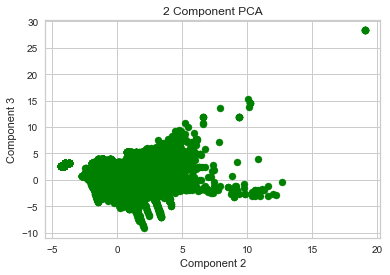

In [92]:
plt.figure()
plt.xlabel('Component 2')
plt.ylabel('Component 3')
plt.title('2 Component PCA')
plt.scatter(PCA_dataset['Component 2'], PCA_dataset['Component 3'], c = 'green', s=50)

In [106]:
from sklearn.cluster import DBSCAN
model = DBSCAN(eps = 0.5, min_samples=100, metric='euclidean').\
fit(principalComponents)
model

DBSCAN(min_samples=100)

In [107]:
DBSCAN_clustered = PCA_dataset.copy()
DBSCAN_clustered.loc[:,'Cluster'] = model.labels_ # append labels to points

In [108]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes


,DBSCAN_size
Cluster,
-1,5111
0,145659
1,138
2,384
3,108
4,3375


In [109]:
from collections import Counter
outliers_df = PCA_dataset[model.labels_ == -1]
clusters_df = PCA_dataset[model.labels_ != -1]
colors = model.labels_
colors_clusters = colors[colors != -1]
colors_outliers = 'black'
clusters = Counter(model.labels_)
print(clusters)
print(PCA_dataset[model.labels_ == -1].head())
print("Number of clusters = {}".format(len(clusters)-1))

Counter({0: 145659, -1: 5111, 4: 3375, 2: 384, 1: 138, 3: 108})
     Component 1  Component 2  Component 3
870     2.890847     3.726064    -2.515070
871     1.740441     3.649873    -1.849850
872     2.316617     3.695667    -2.169681
873     3.465725     3.761590    -2.851947
874     1.164265     3.604080    -1.530020
Number of clusters = 5


C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



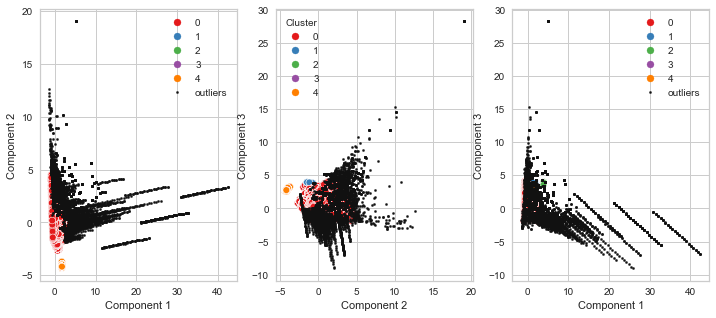

In [119]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,3,figsize=(12,5))


sns.scatterplot('Component 1', 'Component 2',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Component 2', 'Component 3',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

sns.scatterplot('Component 1', 'Component 3',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[2], palette='Set1', legend='full', s=45)

axes[0].scatter(outliers['Component 1'], outliers['Component 2'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Component 2'], outliers['Component 3'], s=5, label='outliers', c="k")
axes[2].scatter(outliers['Component 1'], outliers['Component 3'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend
axes[2].legend()


plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')
plt.setp(axes[2].get_legend().get_texts(), fontsize='10')

plt.show()


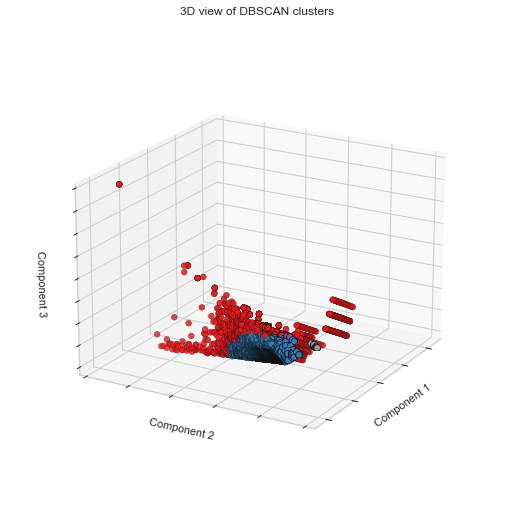

In [120]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(DBSCAN_clustered['Component 1'],
           DBSCAN_clustered['Component 2'],
           DBSCAN_clustered['Component 3'],
           c=DBSCAN_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Component 1')
ax.set_ylabel('Component 2')
ax.set_zlabel('Component 3')
ax.set_title('3D view of DBSCAN clusters')
ax.dist = 12

plt.show()


In [171]:
# segmentation RFM

In [187]:
df = pd.read_csv("projet4_segmentation.csv", index_col=0)
df.head()

,payment_sequential,payment_type,payment_installments,payment_value,seller_id,customer_id,order_purchase_timestamp,order_delivered_customer_date,order_purchase_month,order_purchase_dayofweek,...,sport,technology,toys_baby,nb_items,nb_review,review_score_mean,nb_orders,delivery_delta_days,First_purchase_date,Last_Purchase_Date
0,1,credit_card,8,99.33,213b25e6f54661939f11710a6fddb871,0a8556ac6be836b46b3e89920d59291c,2018-04-25 22:01:49,2018-05-09 17:36:51,4,2,...,0.0,0.0,0.0,1.0,1,1.0,1,14.0,201804,201804
1,1,credit_card,4,93.72,213b25e6f54661939f11710a6fddb871,0e37385834260d6111727103a93e790a,2018-04-15 22:53:59,2018-04-20 00:07:39,4,6,...,0.0,0.0,0.0,1.0,1,4.0,1,4.0,201804,201804
2,1,credit_card,1,24.39,eaf6d55068dea77334e8477d3878d89e,f2c7fc58a9de810828715166c672f10a,2018-06-26 11:01:38,2018-06-29 20:32:09,6,1,...,0.0,0.0,0.0,1.0,1,5.0,1,3.0,201806,201806
3,1,credit_card,1,65.71,cc419e0650a3c5ba77189a1882b7556a,25b14b69de0b6e184ae6fe2755e478f9,2017-12-12 11:19:55,2017-12-18 17:24:41,12,1,...,0.0,0.0,0.0,1.0,1,5.0,1,6.0,201712,201712
4,1,credit_card,2,65.71,cc419e0650a3c5ba77189a1882b7556a,49a332427c5be4c418541be8753c5238,2018-02-13 18:37:48,2018-02-16 17:48:45,2,1,...,0.0,0.0,0.0,1.0,1,4.0,1,3.0,201802,201802


In [188]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154775 entries, 0 to 154774
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   payment_sequential             154775 non-null  int64  
 1   payment_type                   154775 non-null  object 
 2   payment_installments           154775 non-null  int64  
 3   payment_value                  154775 non-null  float64
 4   seller_id                      154775 non-null  object 
 5   customer_id                    154775 non-null  object 
 6   order_purchase_timestamp       154775 non-null  object 
 7   order_delivered_customer_date  154775 non-null  object 
 8   order_purchase_month           154775 non-null  int64  
 9   order_purchase_dayofweek       154775 non-null  int64  
 10  customer_unique_id             154775 non-null  object 
 11  customer_zip_code_prefix       154775 non-null  int64  
 12  customer_city                 

In [189]:
datetime_cols = ["order_purchase_timestamp", 
                     "order_delivered_customer_date"]
for col in datetime_cols:
        df[col] = df[col].astype('datetime64[ns]')

In [ ]:
# Recency

In [190]:
# creates a generic user dataframe to keep CustomerID and new segmentation scores
df_user = pd.DataFrame(df['customer_unique_id'])
df_user.columns = ['customer_unique_id']

# gets the max purchase date for each customer and create a dataframe with it
df_purchase_max = df.groupby('customer_unique_id').order_purchase_timestamp.max().reset_index()
df_purchase_max.columns = ['customer_unique_id', 'Last_Purchase_Date']

# we take our observation point as the max purchase date in our dataset
df_purchase_max['Recency'] = (df_purchase_max['Last_Purchase_Date'].max() - df_purchase_max['Last_Purchase_Date']).dt.days

# merge this dataframe to our new user dataframe
df_user = pd.merge(df_user, df_purchase_max[['customer_unique_id','Recency']], on='customer_unique_id')

df_user.head()


,customer_unique_id,Recency
0,708ab75d2a007f0564aedd11139c7708,125
1,550a1a0e8ad53e4147e6c761b5699c2b,135
2,a8b9d3a27068454b1c98cc67d4e31e6f,64
3,6f70c0b2f7552832ba46eb57b1c5651e,260
4,4847d361361a3440824346865cf03f83,196


In [191]:
# getting summary statistics of the recency table
df_user.Recency.describe()

count    154775.000000
mean        226.067769
std         153.309205
min           0.000000
25%         103.000000
50%         202.000000
75%         332.000000
max         694.000000
Name: Recency, dtype: float64

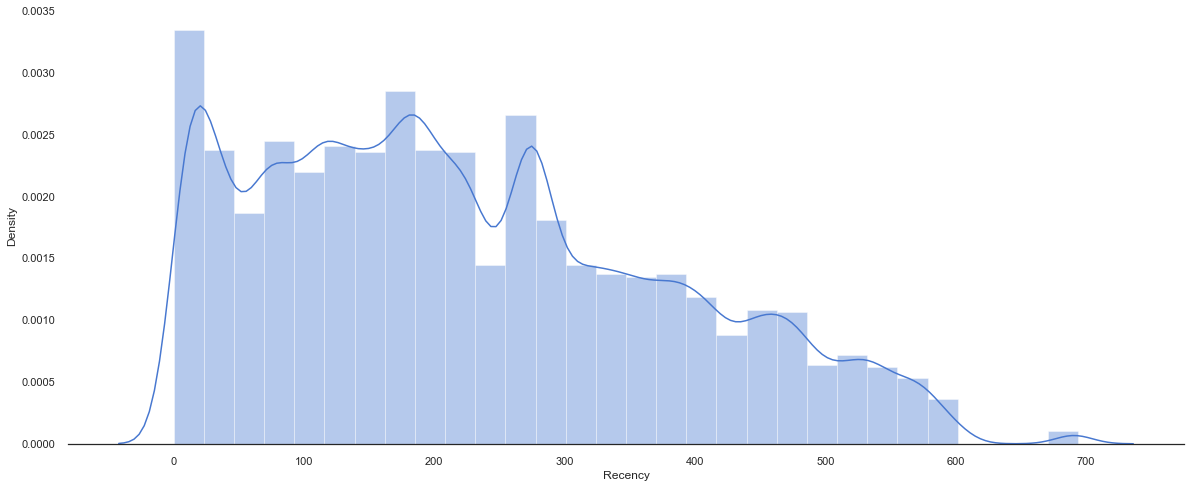

In [192]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='white')
fig, ax = plt.subplots(figsize=(20, 8))
sns.despine(left=True)
sns.distplot(df_user['Recency'], bins=30)
plt.show()

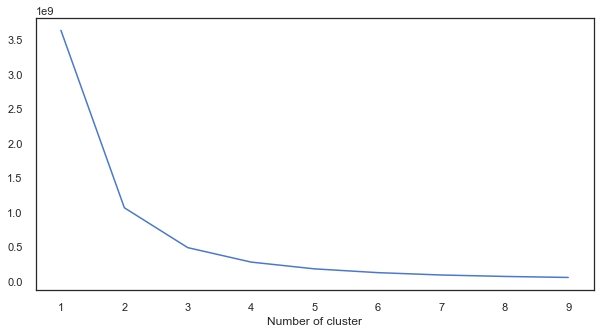

In [193]:
from sklearn.cluster import KMeans

sse={}
df_recency = df_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_recency)
    df_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()


In [194]:
# building 3 clusters for recency and adding it to dataframe
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Recency']])
df_user['Recency_Cluster'] = kmeans.predict(df_user[['Recency']])

# function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

df_user = order_cluster('Recency_Cluster', 'Recency',df_user,False)


In [195]:
# displaying the details of each cluster
df_user.groupby('Recency_Cluster')['Recency'].describe()


,count,mean,std,min,25%,50%,75%,max
Recency_Cluster,,,,,,,,
0,35140.0,451.912664,72.128257,349.0,391.0,443.0,505.0,694.0
1,58732.0,244.576023,52.560122,162.0,196.0,238.0,282.0,348.0
2,60903.0,77.910596,48.521544,0.0,31.0,78.0,119.0,161.0


In [ ]:
# Frequency

In [196]:
# Frequency
# get order counts for each user and create a dataframe with it
df_frequency = df.groupby('customer_unique_id').order_purchase_timestamp.count().reset_index()
df_frequency.columns = ['customer_unique_id','Frequency']

# add this data to our main dataframe
df_user = pd.merge(df_user, df_frequency, on='customer_unique_id')

In [197]:
# getting summary statistics of the recency table
df_user.Frequency.describe()

count    154775.000000
mean        100.705547
std         502.547267
min           1.000000
25%           1.000000
50%           1.000000
75%           8.000000
max        3375.000000
Name: Frequency, dtype: float64

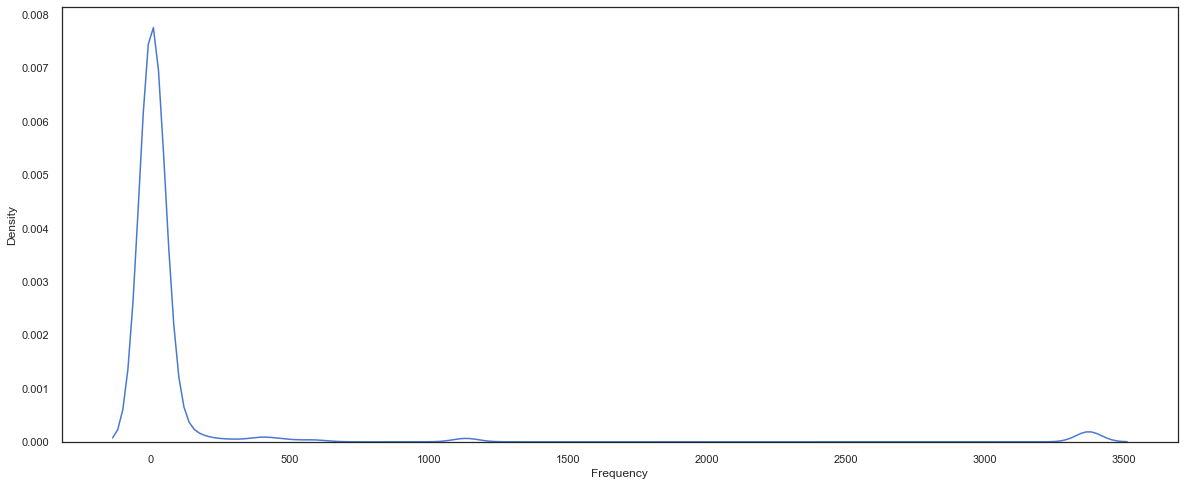

In [198]:
# plotting the distribution of the continous feature set

fig, ax = plt.subplots(figsize=(20, 8))
sns.distplot(df_user['Frequency'], hist=False)
plt.show()

In [199]:
# k-means
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['Frequency']])
df_user['Frequency_Cluster'] = kmeans.predict(df_user[['Frequency']])

# order the frequency cluster
df_user = order_cluster('Frequency_Cluster', 'Frequency',df_user,True)

# see details of each cluster
df_user.groupby('Frequency_Cluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
Frequency_Cluster,,,,,,,,
0,147571.0,11.307825,31.923004,1.0,1.0,1.0,8.0,300.0
1,3829.0,660.059807,314.069831,384.0,396.0,490.0,1134.0,1134.0
2,3375.0,3375.000000,0.000000,3375.0,3375.0,3375.0,3375.0,3375.0


In [ ]:
# Monetary

In [200]:
# Revenue
# calculate revenue for each customer
df_revenue = df.groupby('customer_unique_id').payment_value.sum().reset_index()

# merge it with our main dataframe
df_user = pd.merge(df_user, df_revenue, on='customer_unique_id')

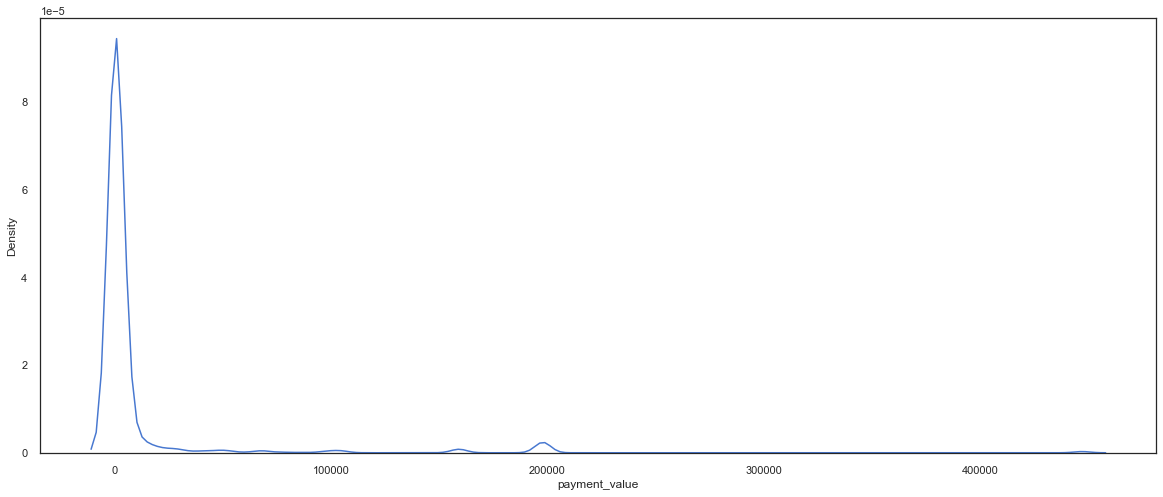

In [201]:
# plotting the distribution of the continous feature set

fig, ax = plt.subplots(figsize=(20, 8))
sns.distplot(df_user['payment_value'], hist=False)
plt.show()

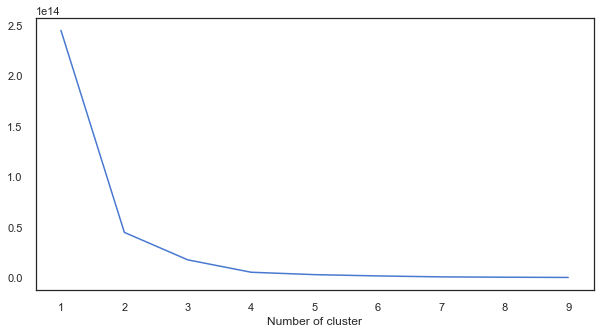

In [202]:
sse={}
df_revenue = df_user[['payment_value']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(df_revenue)
    df_revenue["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

In [203]:
# apply clustering
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_user[['payment_value']])
df_user['Revenue_Cluster'] = kmeans.predict(df_user[['payment_value']])


# order the cluster numbers
df_user = order_cluster('Revenue_Cluster', 'payment_value',df_user,True)

# show details of the dataframe
df_user.groupby('Revenue_Cluster')['payment_value'].describe()

,count,mean,std,min,25%,50%,75%,max
Revenue_Cluster,,,,,,,,
0,148830.0,2361.380817,8.237854e+03,9.59,86.44,205.235,916.32,86417.28
1,5561.0,171705.221703,3.716530e+04,97576.92,159049.98,197835.750,197835.75,197835.75
2,384.0,446967.360000,1.631941e-09,446967.36,446967.36,446967.360,446967.36,446967.36


In [204]:
# Overall Score
# renaming columns
df_user.columns = ['customer_unique_id', 'Recency', 'Recency_Cluster', 'Frequency', 'Frequency_Cluster', 'Monetary', 'Revenue_Cluster']
# calculate overall score and use mean() to see details
df_user['OverallScore'] = df_user['Recency_Cluster'] + df_user['Frequency_Cluster'] + df_user['Revenue_Cluster']
df_user.groupby('OverallScore')['Recency','Frequency','Monetary'].mean()

,Recency,Frequency,Monetary
OverallScore,,,
0,451.912664,10.950882,953.905028
1,246.223240,9.573380,2021.130318
2,83.976023,17.462976,2902.855493
3,136.741507,807.903988,112211.250620
4,55.597561,510.731707,101531.960976
5,9.328013,3069.454908,223285.746872


In [205]:
df_user['Segment'] = 'Low-Value'
df_user.loc[df_user['OverallScore']>1,'Segment'] = 'Mid-Value' 
df_user.loc[df_user['OverallScore']>3,'Segment'] = 'High-Value' 

In [206]:
df_user.head()

,customer_unique_id,Recency,Recency_Cluster,Frequency,Frequency_Cluster,Monetary,Revenue_Cluster,OverallScore,Segment
0,708ab75d2a007f0564aedd11139c7708,125,2,1,0,99.33,0,2,Mid-Value
1,550a1a0e8ad53e4147e6c761b5699c2b,135,2,1,0,93.72,0,2,Mid-Value
2,a8b9d3a27068454b1c98cc67d4e31e6f,64,2,1,0,24.39,0,2,Mid-Value
3,94cffd1e5129cf8537e1d034e553c259,153,2,1,0,65.22,0,2,Mid-Value
4,56e674dd2fe123d7ddd38e34b53163ac,39,2,1,0,57.60,0,2,Mid-Value


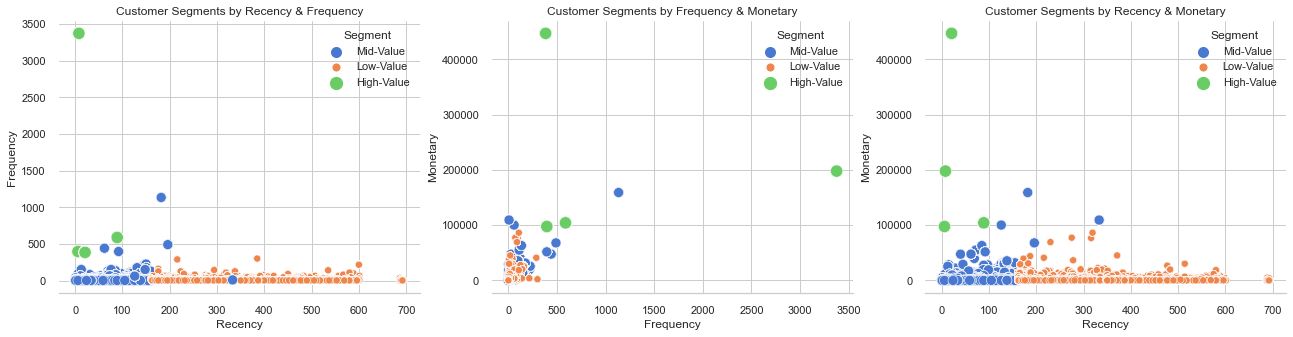

In [207]:
# plotting the distribution of the continous feature set
sns.set(palette='muted', color_codes=True, style='whitegrid')
fig, axs = plt.subplots(1, 3, figsize=(22, 5))
sns.despine(left=True)
sns.scatterplot(x='Recency', y='Frequency', ax=axs[0], hue='Segment', data=df_user, size='Segment', sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Frequency', y='Monetary', ax=axs[1], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
sns.scatterplot(x='Recency', y='Monetary', ax=axs[2], hue='Segment', data=df_user, size='Segment' , sizes=(50,150), size_order=['High-Value','Mid-Value','Low-Value'])
axs[0].set_title('Customer Segments by Recency & Frequency')
axs[1].set_title('Customer Segments by Frequency & Monetary')
axs[2].set_title('Customer Segments by Recency & Monetary')
plt.show()